In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from random import randint

In [2]:
path_df = pd.read_csv("../COVIDdata/PatientRoute.csv")

In [3]:
path_df

,patient_id,date,province,city,type,latitude,longitude
0,1000000001,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.61525,126.7156
1,1000000001,2020-01-24,Seoul,Jung-gu,hospital,37.56724,127.0057
2,1000000002,2020-01-25,Seoul,Seongbuk-gu,etc,37.59256,127.0170
3,1000000002,2020-01-26,Seoul,Seongbuk-gu,store,37.59181,127.0168
4,1000000002,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56399,127.0295
...,...,...,...,...,...,...,...
10405,6100000098,2020-03-28,Seoul,Dobong-gu,hospital,37.64586,127.0286
10406,6100000120,2020-05-16,Gyeonggi-do,Gunpo-si,etc,37.36167,126.9352
10407,6100000120,2020-05-16,Gyeonggi-do,Suwon-si,public_transportation,37.28214,126.9699
10408,6100000120,2020-05-16,Daegu,Jung-gu,etc,35.87144,128.6014


In [4]:
condition = (path_df['province']=="Seoul") | (path_df['province']=="Gyeonggi-do")

In [5]:
set(path_df[condition]['city']).__len__()

54

In [6]:
travel_df = path_df[condition]

In [7]:
# travel_df.to_csv("../csv/COVID_travel_df.csv")

In [8]:
travel_df

,patient_id,date,province,city,type,latitude,longitude
0,1000000001,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.61525,126.7156
1,1000000001,2020-01-24,Seoul,Jung-gu,hospital,37.56724,127.0057
2,1000000002,2020-01-25,Seoul,Seongbuk-gu,etc,37.59256,127.0170
3,1000000002,2020-01-26,Seoul,Seongbuk-gu,store,37.59181,127.0168
4,1000000002,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56399,127.0295
...,...,...,...,...,...,...,...
10399,6100000090,2020-03-24,Seoul,Gangseo-gu,airport,37.55865,126.7945
10404,6100000097,2020-03-26,Seoul,Dobong-gu,hospital,37.64586,127.0286
10405,6100000098,2020-03-28,Seoul,Dobong-gu,hospital,37.64586,127.0286
10406,6100000120,2020-05-16,Gyeonggi-do,Gunpo-si,etc,37.36167,126.9352


In [9]:
# Create from / to / date dataframe.
# This takes < 1hour for european travel datasets
from datetime import timedelta 
from datetime import datetime

from_to_df=None
travel_start=0
# travel_end=0
for i in range(1,len(travel_df)):
    if i % 1000 == 0:
        print(i)
    if(travel_df.iloc[i,0] != travel_df.iloc[i-1,0]):
        travel_start = travel_df.iloc[i,3]
    else:
        b =np.array([travel_df.iloc[i,0], travel_df.iloc[i,1], travel_df.iloc[i-1,3], travel_df.iloc[i,3]])
        if from_to_df is not None:
            from_to_df = np.vstack((from_to_df,b))
        else:
            from_to_df = b

1000
2000
3000
4000
5000


In [10]:
concat_df =pd.DataFrame(from_to_df)
concat_df.columns = ['patient_id','date','from','to']
concat_df['date'] = pd.to_datetime(travel_df['date'])

In [11]:
concat_df

,patient_id,date,from,to
0,1000000001,2020-01-22,Gimpo-si,Jung-gu
1,1000000002,2020-01-24,Seongbuk-gu,Seongbuk-gu
2,1000000002,2020-01-25,Seongbuk-gu,Seongdong-gu
3,1000000002,2020-01-26,Seongdong-gu,Seongbuk-gu
4,1000000002,2020-01-26,Seongbuk-gu,Seongbuk-gu
...,...,...,...,...
4362,6100000035,2020-06-04,Suwon-si,Suwon-si
4363,6100000035,2020-06-04,Suwon-si,Suwon-si
4364,6100000035,2020-06-04,Suwon-si,Suwon-si
4365,6100000090,2020-06-05,Gangseo-gu,Gangseo-gu


In [12]:
# Initialize Graph model. 
G = nx.DiGraph()
nodes = travel_df['city'].unique().T
for u in nodes:
    for v in nodes:
        G.add_edge(u,v)
        G[u][v]['weight'] = 0

In [13]:
travel_df['city'].unique().T # 226 country

array(['Gimpo-si', 'Jung-gu', 'Seongbuk-gu', 'Seongdong-gu',
       'Dongdaemun-gu', 'Jungnang-gu', 'Gangnam-gu', 'Jongno-gu',
       'Goyang-si', 'Seongnam-si', 'Songpa-gu', 'Seodaemun-gu', 'Mapo-gu',
       'Uijeongbu-si', 'Dongducheon-si', 'Eunpyeong-gu', 'Seocho-gu',
       'Gwacheon-si', 'Gwangjin-gu', 'Guro-gu', 'Dobong-gu', 'Dongjak-gu',
       'Namyangju-si', 'Yongsan-gu', 'Yeongdeungpo-gu', 'Icheon-si',
       'Suwon-si', 'Pyeongtaek-si', 'Paju-si', 'Geumcheon-gu',
       'Gangdong-gu', 'Nowon-gu', 'Yangcheon-gu', 'Gangseo-gu',
       'Gwanak-gu', 'Anyang-si', 'Gunpo-si', 'Gangbuk-gu', 'Yongin-si',
       'Gwangju-si', 'Ansan-si', 'Bucheon-si', 'Hanam-si', 'Siheung-si',
       'Yangpyeong-gun', 'Yeoncheon-gun', 'Gwangmyeong-si', 'Yeoju-si',
       'Guri-si', 'Hwaseong-si', 'Uiwang-si', 'Anseong-si', 'Pocheon-si',
       'Osan-si'], dtype=object)

In [16]:
# day_slices = pd.date_range('2020-01-20', periods=22*7, freq='D')
# day_slices

week_slices = pd.date_range('2020-01-19', periods=23, freq='W')
week_slices

DatetimeIndex(['2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21'],
              dtype='datetime64[ns]', freq='W-SUN')

In [17]:
# Create a series of graphs by time
import copy
# Tintervals = 6
w_slices = week_slices
time_dim = len(w_slices) -1 # subtract -1 becuase the number of time slices is less than time points by 1
serial_graphs = []
for t in range(0, time_dim):
    temp_G = copy.deepcopy(G) # we need a deep copy to create various graphs
    df_by_time = concat_df[(concat_df['date']>= w_slices[t])&(concat_df['date']< w_slices[t+1])]
    def add_weight(u,v):
        if u!=v:
            temp_G[u][v]['weight'] +=1
        return 0
    df_by_time.apply(lambda x: add_weight(x['from'],x['to']), axis=1)
    serial_graphs.append(temp_G)

In [18]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as output:  # Overwrites any existing file.
#         pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# save_object(serial_graphs, '../pkl/COVID_weekly_graphs.pkl')

In [19]:
travel_df['city'].unique().T[19]

'Guro-gu'

In [20]:
t = 7
G = serial_graphs[t]
mat = nx.adjacency_matrix(G).todense()
np.sum(mat[:,19])

12

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use

trips between 2020-03-08 00:00:00 and 2020-03-15 00:00:00


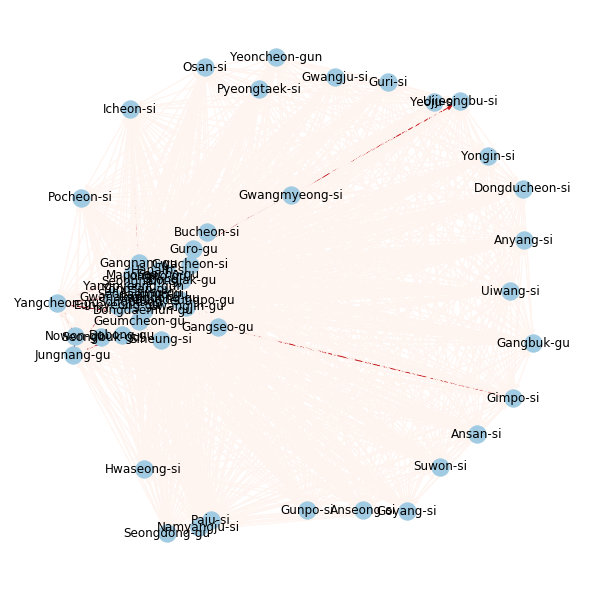

In [21]:
# # You may draw a graph 
import matplotlib.pyplot as plt
t = 7
G = serial_graphs[t]
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G)
colors = np.asarray(weights)
colors = np.log(colors+0.001)-min(np.log(colors+0.001))
plt.figure(figsize=(8,8)) 
nx.draw(G, pos, node_color='#A0CBE2', edgelist=edges, edge_color=colors, with_labels = True, edge_cmap=plt.get_cmap('Reds'))
print("trips between",week_slices[t],"and",week_slices[t+1])
plt.show()

trips between 2020-03-01 00:00:00 and 2020-03-08 00:00:00


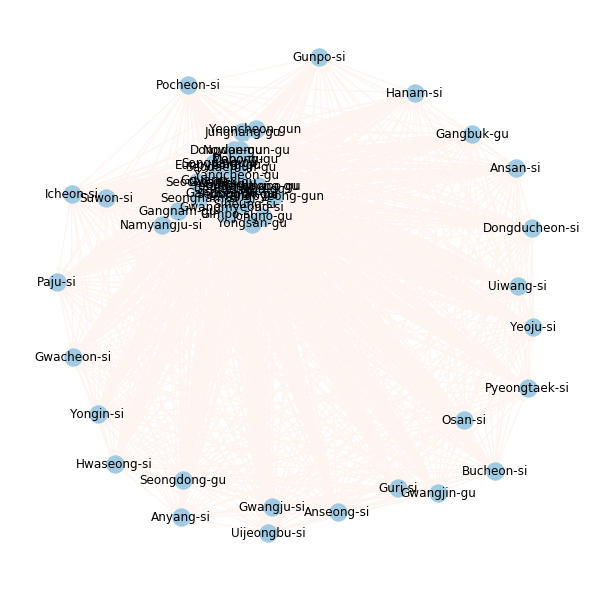

In [22]:
# # You may draw a graph 
import matplotlib.pyplot as plt
t = 6
G = serial_graphs[t]
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G)
colors = np.asarray(weights)
colors = np.log(colors+0.001)-min(np.log(colors+0.001))
plt.figure(figsize=(8,8)) 
nx.draw(G, pos, node_color='#A0CBE2', edgelist=edges, edge_color=colors, with_labels = True, edge_cmap=plt.get_cmap('Reds'))
print("trips between",week_slices[t],"and",week_slices[t+1])
plt.show()

In [23]:
# Create tensors whose dimension is Time x Nodes x Featrues
# Here we refer the paper of 'Anomaly detection in spatiotemporal data via regularized non-negative tensor analysis'
# The number of features = 2 x the number of Nodes
import tensorly.backend as T
time_dim # the number of slices by time which we set above.
n_nodes = travel_df['city'].unique().size
tensor = T.tensor(np.zeros(time_dim * n_nodes * 2*n_nodes).reshape((time_dim, n_nodes, 2*n_nodes))) # Time x Nodes x Features

In [24]:
# Fill the Tensors
for i in range(0,time_dim):    
    mat = nx.adjacency_matrix(serial_graphs[i]).todense()
    feature_mat = np.hstack((mat, mat.T)) # Feature matrix.
    tensor[i] = feature_mat
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [25]:
serial_graphs[0]

In [26]:
tensor.shape

(22, 54, 108)

In [30]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(tensor, '../pkl/COVID_weekly_tensor_ver2.pkl')

In [28]:
cases = np.sum(np.sum(tensor[:,:,:54], axis=1), axis=1)

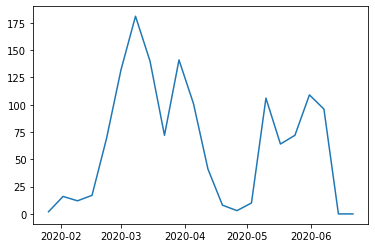

In [29]:
plt.plot(week_slices[1:],cases)